In [4]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy

import jastrowspin
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [5]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [6]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = H2_casci(scf_checkfile, ci_checkfile)
# mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [34]:
from wftools import generate_jastrow
jastrow, to_opt = generate_jastrow(mol, ion_cusp = False, na = 0) # nb = 0)

In [35]:
def fixed_initial_guess(mol, nconfig, r=1.0):
    from pyqmc.coord import OpenConfigs, PeriodicConfigs

    epos = np.zeros((nconfig, np.sum(mol.nelec), 3))
    wts = mol.atom_charges()
    wts = wts / np.sum(wts)
    ind0 = 0
    for s in [0, 1]:
        neach = np.array(
            np.floor(mol.nelec[s] * wts), dtype=int
        )  # integer number of elec on each atom
        nleft = (
            mol.nelec[s] * wts - neach
        )  # fraction of electron unassigned on each atom
        nassigned = np.sum(neach)  # number of electrons assigned
        totleft = int(mol.nelec[s] - nassigned)  # number of electrons not yet assigned
        # 
        max = 4
        min = 1
        if ind0 > 0:
            max = 2
            min = 2
        epos[:, ind0, :] = np.linspace([0.1,0.1,min], [0.1,0.1,max], num=nconfig)
        ind0 += 1
    if hasattr(mol, "a"):
        epos = PeriodicConfigs(epos, mol.lattice_vectors())
    else:
        epos = OpenConfigs(epos)
    
    return epos

In [36]:
import bosonrecipes
import mc
modules = [mc]
for m in modules:
    importlib.reload(m)

import mc
nconfig = 1000
configs = fixed_initial_guess(mol, nconfig)
x = configs.configs[:,0][:,2] # fixed electron is index 1, z coordinate
configs.configs

array([[[0.1       , 0.1       , 1.        ],
        [0.1       , 0.1       , 2.        ]],

       [[0.1       , 0.1       , 1.003003  ],
        [0.1       , 0.1       , 2.        ]],

       [[0.1       , 0.1       , 1.00600601],
        [0.1       , 0.1       , 2.        ]],

       ...,

       [[0.1       , 0.1       , 3.99399399],
        [0.1       , 0.1       , 2.        ]],

       [[0.1       , 0.1       , 3.996997  ],
        [0.1       , 0.1       , 2.        ]],

       [[0.1       , 0.1       , 4.        ],
        [0.1       , 0.1       , 2.        ]]])

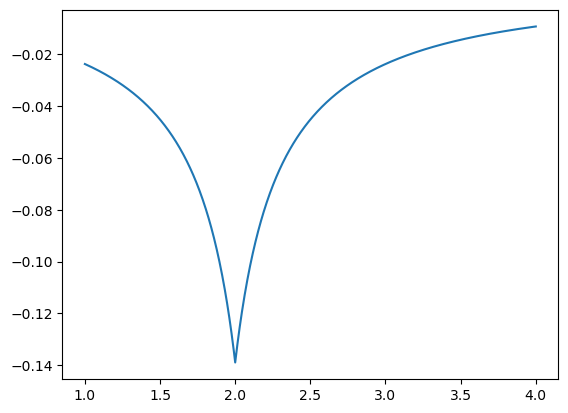

In [37]:
s, v = jastrow.recompute(configs)
plt.plot(x, v)

In [38]:
e = 0
g, _, _ = jastrow.gradient_value(e, configs.electron(e))
g_num = np.gradient(v, x) 

In [39]:
g.shape

(3, 1000)

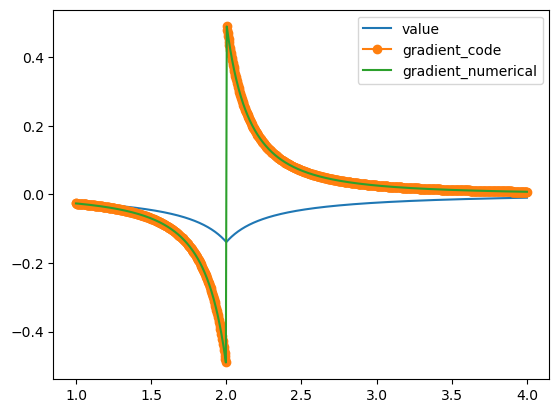

In [40]:
# plt.plot(x, v)
plt.plot(x, v, label='value')
plt.plot(x, g[2], '-o', label='gradient_code')
plt.plot(x, g_num, label='gradient_numerical')
plt.legend()

In [41]:
e = 0
# g, l = jastrow.gradient_laplacian(e, configs.electron(e))
lcode = jastrow.laplacian(e, configs.electron(e))
l_num = np.gradient(np.gradient(np.exp(v), x), x)

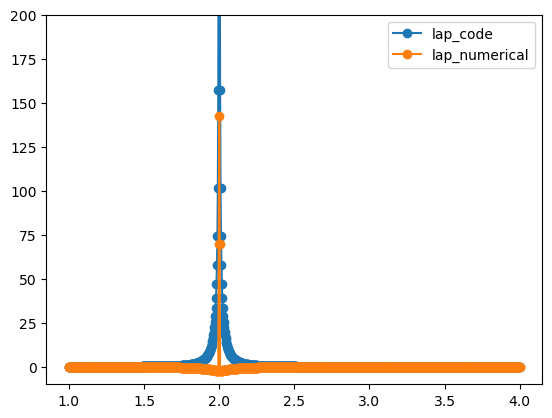

In [46]:
plt.plot(x, lcode, '-o', label='lap_code')
plt.plot(x, l_num, '-o', label='lap_numerical')
plt.ylim((-10, 200))
plt.legend()

In [227]:
import gpu 
epos = configs.electron(e)
self = jastrow
nconf, nelec = self._configscurrent.configs.shape[:2]
nup = self._mol.nelec[0]

# Get e-e and e-ion distances
not_e = np.arange(nelec) != e
dnew = gpu.cp.asarray(
    epos.dist.dist_i(self._configscurrent.configs, epos.configs)[:, not_e]
)
dinew = gpu.cp.asarray(epos.dist.dist_i(self.atom_coords, epos.configs))
rnew = gpu.cp.linalg.norm(dnew, axis=-1)
rinew = gpu.cp.linalg.norm(dinew, axis=-1)

eup = int(e < nup)
edown = int(e >= nup)


In [231]:
# self.a_basis[0].value(None, rnew).shape

In [255]:
def a_val_grad_lap(jastrow, e, epos):
    self = jastrow
    nconf, nelec = self._configscurrent.configs.shape[:2]
    nup = self._mol.nelec[0]

    # Get e-e and e-ion distances
    not_e = np.arange(nelec) != e
    dnew = gpu.cp.asarray(
        epos.dist.dist_i(self._configscurrent.configs, epos.configs)[:, not_e]
    )
    dinew = gpu.cp.asarray(epos.dist.dist_i(self.atom_coords, epos.configs))
    rnew = gpu.cp.linalg.norm(dnew, axis=-1)
    rinew = gpu.cp.linalg.norm(dinew, axis=-1)

    eup = int(e < nup)
    edown = int(e >= nup)

    grad = gpu.cp.zeros((3, nconf))
    lap = gpu.cp.zeros(nconf)
    val = gpu.cp.zeros((nconf, 1))
    # a-value component
    for c, a in zip(self.parameters["acoeff"].transpose()[edown], self.a_basis):
        val += a.value(None, rnew)
        g, l = a.gradient_laplacian(dinew, rinew)
        grad += gpu.cp.einsum("j,ijk->ki", c, g)
        lap += gpu.cp.einsum("j,ijk->i", c, l)
    return val.ravel(), grad, lap, rnew.ravel()
    # return rnew

val, grad, lap, rnew = a_val_grad_lap(jastrow, e, epos) 

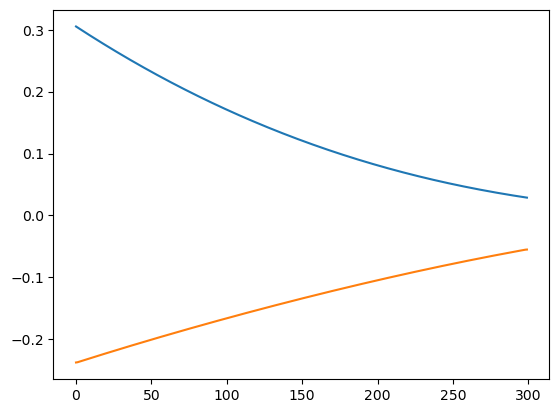

In [256]:
plt.plot(val)
plt.plot(np.gradient(val, rnew))

In [257]:
def b_val_grad_lap(jastrow, e, epos):
    self = jastrow
    nconf, nelec = self._configscurrent.configs.shape[:2]
    nup = self._mol.nelec[0]

    # Get e-e and e-ion distances
    not_e = np.arange(nelec) != e
    dnew = gpu.cp.asarray(
        epos.dist.dist_i(self._configscurrent.configs, epos.configs)[:, not_e]
    )
    dinew = gpu.cp.asarray(epos.dist.dist_i(self.atom_coords, epos.configs))
    rnew = gpu.cp.linalg.norm(dnew, axis=-1)
    rinew = gpu.cp.linalg.norm(dinew, axis=-1)

    eup = int(e < nup)
    edown = int(e >= nup)

    grad = gpu.cp.zeros((3, nconf))
    lap = gpu.cp.zeros(nconf)
    val = gpu.cp.zeros((nconf, 1))
    # a-value component
    # b-value component
    for c, b in zip(self.parameters["bcoeff"], self.b_basis):
        bgrad, blap = b.gradient_laplacian(dnew, rnew)
        val += b.value(None, rnew)
        grad += c[edown] * gpu.cp.sum(bgrad[:, : nup - eup], axis=1).T
        grad += c[1 + edown] * gpu.cp.sum(bgrad[:, nup - eup :], axis=1).T
        lap += c[edown] * gpu.cp.sum(blap[:, : nup - eup], axis=(1, 2))
        lap += c[1 + edown] * gpu.cp.sum(blap[:, nup - eup :], axis=(1, 2))    

    return val.ravel(), grad, lap, rnew.ravel()
    # return rnew

val, grad, lap, rnew = b_val_grad_lap(jastrow, e, epos) 

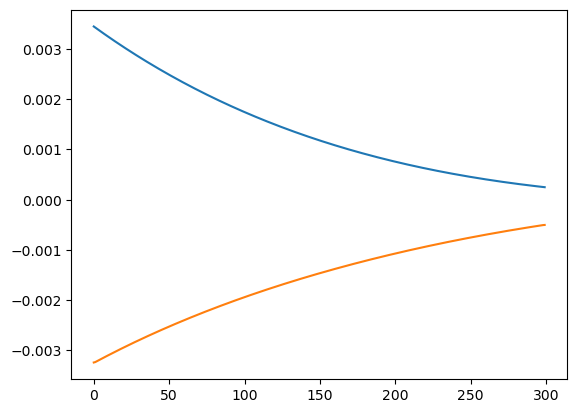

In [258]:
plt.plot(val)
plt.plot(np.gradient(val, rnew))

In [254]:
def laplacian_ks(jastrow, e, epos):
    import gpu
    self = jastrow
    nconf, nelec = self._configscurrent.configs.shape[:2]
    nup = self._mol.nelec[0]

    # Get e-e and e-ion distances
    not_e = np.arange(nelec) != e
    dnew = gpu.cp.asarray(
        epos.dist.dist_i(self._configscurrent.configs, epos.configs)[:, not_e]
    )
    dinew = gpu.cp.asarray(epos.dist.dist_i(self.atom_coords, epos.configs))
    rnew = gpu.cp.linalg.norm(dnew, axis=-1)
    rinew = gpu.cp.linalg.norm(dinew, axis=-1)

    eup = int(e < nup)
    edown = int(e >= nup)

    grad = gpu.cp.zeros((3, nconf))
    lap = gpu.cp.zeros(nconf)
    # a-value component
    for c, a in zip(self.parameters["acoeff"].transpose()[edown], self.a_basis):
        g, l = a.gradient_laplacian(dinew, rinew)
        grad += gpu.cp.einsum("j,ijk->ki", c, g)
        lap += gpu.cp.einsum("j,ijk->i", c, l)

    # b-value component
    for c, b in zip(self.parameters["bcoeff"], self.b_basis):
        bgrad, blap = b.gradient_laplacian(dnew, rnew)

        grad += c[edown] * gpu.cp.sum(bgrad[:, : nup - eup], axis=1).T
        grad += c[1 + edown] * gpu.cp.sum(bgrad[:, nup - eup :], axis=1).T
        lap += c[edown] * gpu.cp.sum(blap[:, : nup - eup], axis=(1, 2))
        lap += c[1 + edown] * gpu.cp.sum(blap[:, nup - eup :], axis=(1, 2))    
    return lap

lap_ks = laplacian_ks(jastrow, e, configs.electron(e))

In [207]:
# Approximate laplacian
right = v[1:-1,]-v[2:]
left = v[0:-2,]-v[1:-1]
h2 = (x[0]-x[1])**2
lap = (left-right)/h2

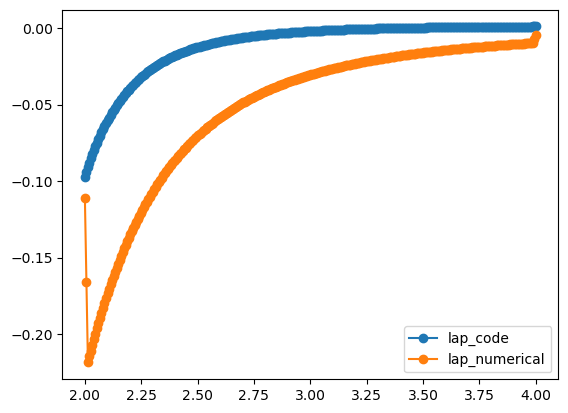

In [208]:
# plt.plot(x, v)
# plt.plot(x, v, label='value')
# plt.plot(x, g[2], label='gradient')
# plt.plot(x, l-g[2]**2, '-o', label='lap_code')
# plt.plot(x, g[2]**2, '-o', label='lap_codeg')
plt.plot(x, lcode, '-o', label='lap_code')
plt.plot(x, -l_num, '-o', label='lap_numerical')
# plt.plot(x, lap_ks, '-o', label='lap_ks')
# plt.plot(x[1:-1], -lap, label='lap_2')
plt.legend()